In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [128]:
serie_temporal_df = pd.read_csv(r'data\bitcoin_6h_20220101_20240307.csv')
# serie_temporal_df

In [137]:
#calcula simple moving average
def SMA(data, period=30, column='close'):
    return data[column].rolling(window=period).mean()

In [129]:
PERIODO_MEDIA = 15
serie_temporal_df['sma'] = SMA(serie_temporal_df, period=PERIODO_MEDIA)
serie_temporal_df['simple_returns'] = serie_temporal_df['close'].pct_change(1)
serie_temporal_df['log_returns'] = np.log(1+serie_temporal_df['simple_returns'])
serie_temporal_df['ratios'] = serie_temporal_df['close'] / serie_temporal_df['sma']

In [120]:
serie_temporal_df['ratios'].describe()

count    3182.000000
mean        1.000114
std         0.010393
min         0.942205
25%         0.996283
50%         1.000135
75%         1.003774
max         1.056880
Name: ratios, dtype: float64

In [130]:
#remove nans
ratios = serie_temporal_df['ratios'].dropna()
percentiles = [15,20,50,80,85]
percentile_values = np.percentile(ratios, percentiles)
percentile_values

array([0.97744415, 0.98362502, 1.00009835, 1.02012094, 1.0262086 ])

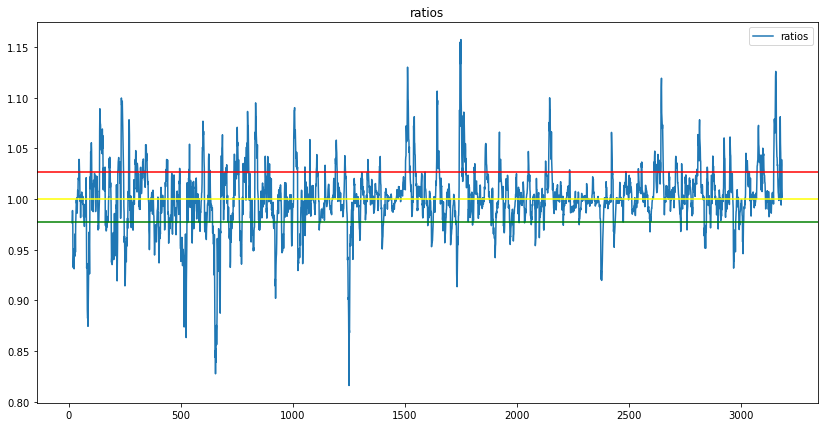

In [131]:
plt.figure(figsize=(14,7))
plt.title('ratios')
serie_temporal_df['ratios'].dropna().plot(legend=True)
plt.axhline(percentile_values[0], c='green', label=f"{percentile_values[0]}th percentile")
plt.axhline(percentile_values[2], c='yellow', label=f"{percentile_values[2]}th percentile")
plt.axhline(percentile_values[-1], c='red', label=f"{percentile_values[-1]}th percentile")


In [132]:
sell = percentile_values[-1]
buy = percentile_values[0]
serie_temporal_df['posicao'] = np.where(serie_temporal_df.ratios > sell, 1, np.nan)
serie_temporal_df['posicao'] = np.where(serie_temporal_df.ratios < buy, -1, serie_temporal_df['posicao'])
serie_temporal_df['posicao'] = serie_temporal_df['posicao'].ffill()
serie_temporal_df['compra'] = np.where(serie_temporal_df.posicao==1, serie_temporal_df['close'], np.nan)
serie_temporal_df['vende'] = np.where(serie_temporal_df.posicao==-1, serie_temporal_df['close'], np.nan)

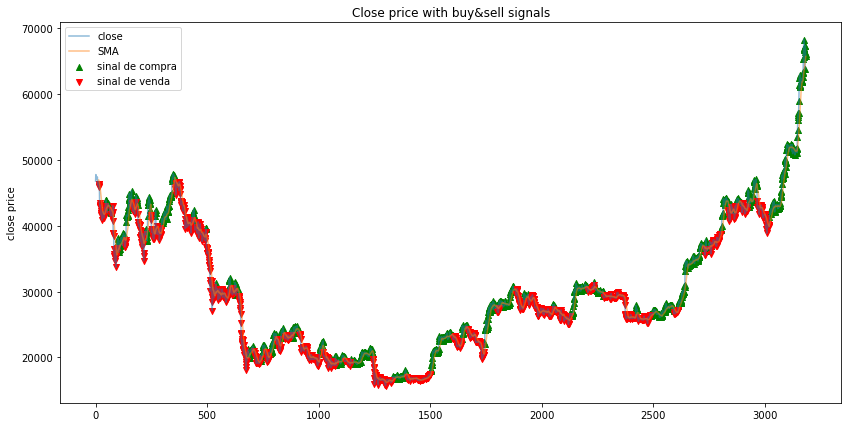

In [133]:
plt.figure(figsize=(14,7))
plt.title('Close price with buy&sell signals')
plt.plot(serie_temporal_df['close'], alpha=0.5, label='close')
plt.plot(serie_temporal_df['sma'], alpha=0.5, label='SMA')
plt.scatter(serie_temporal_df.index, serie_temporal_df['compra'], color='green', label='sinal de compra', marker='^', alpha=1)
plt.scatter(serie_temporal_df.index, serie_temporal_df['vende'], color='red', label='sinal de venda', marker='v', alpha=1)
plt.ylabel('close price')
plt.legend()
plt.show()

In [134]:
serie_temporal_df['lucro_rm'] = serie_temporal_df.posicao.shift(1) * serie_temporal_df.log_returns
# serie_temporal_df['lucro_rm']

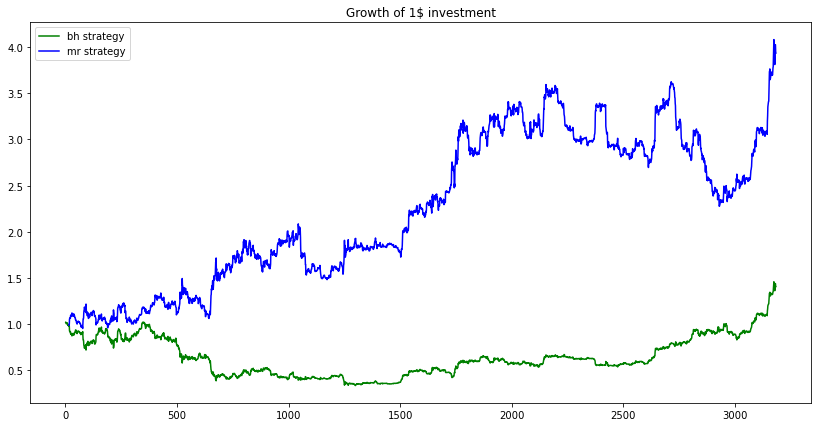

In [135]:
plt.figure(figsize=(14,7))
plt.title('Growth of 1$ investment')
plt.plot(np.exp(serie_temporal_df['log_returns'].dropna()).cumprod(), c='green', label='bh strategy')
plt.plot(np.exp(serie_temporal_df['lucro_rm'].dropna()).cumprod(), c='blue', label='mr strategy')
plt.legend()

In [136]:
print('bh returns:', list(np.exp(serie_temporal_df['log_returns'].dropna()).cumprod())[-1])
print('bh returns:', (list(serie_temporal_df['close'])[-1] - list(serie_temporal_df['close'])[0])/list(serie_temporal_df['close'])[0])
print('mr returns:', list(np.exp(serie_temporal_df['lucro_rm'].dropna()).cumprod())[-1])

bh returns: 1.4072196355472175
bh returns: 0.40721963554722335
mr returns: 3.934939917333481


In [149]:
#testar parametros
frequencia_fonte = ['1d', '12h', '6h', '1h', '30m']
periodo_considerado = list(range(2,31))
result = []
data_inicio = '2022.5.22'
data_fim = '2023.11.4'
for freq in frequencia_fonte:
    for periodo in periodo_considerado:
        serie_temporal_df = pd.read_csv(rf'data\new\bitcoin_{freq}_{data_inicio}_{data_fim}.csv')
        serie_temporal_df['sma'] = SMA(serie_temporal_df, period=periodo)
        serie_temporal_df['simple_returns'] = serie_temporal_df['close'].pct_change(1)
        serie_temporal_df['log_returns'] = np.log(1+serie_temporal_df['simple_returns'])
        serie_temporal_df['ratios'] = serie_temporal_df['close'] / serie_temporal_df['sma']
        ratios = serie_temporal_df['ratios'].dropna()
        percentiles = [15,20,50,80,85]
        percentile_values = np.percentile(ratios, percentiles)
        sell = percentile_values[-1]
        buy = percentile_values[0]
        serie_temporal_df['posicao'] = np.where(serie_temporal_df.ratios > sell, 1, np.nan)
        serie_temporal_df['posicao'] = np.where(serie_temporal_df.ratios < buy, -1, serie_temporal_df['posicao'])
        serie_temporal_df['posicao'] = serie_temporal_df['posicao'].ffill()
        serie_temporal_df['compra'] = np.where(serie_temporal_df.posicao==1, serie_temporal_df['close'], np.nan)
        serie_temporal_df['vende'] = np.where(serie_temporal_df.posicao==-1, serie_temporal_df['close'], np.nan)
        serie_temporal_df['lucro_rm'] = serie_temporal_df.posicao.shift(1) * serie_temporal_df.log_returns
        lucro_bh = list(np.exp(serie_temporal_df['log_returns'].dropna()).cumprod())[-1]
        lucro_rm = list(np.exp(serie_temporal_df['lucro_rm'].dropna()).cumprod())[-1]
        result.append({
            'frequencia_fonte': freq,
            'periodo_considerado': periodo,
            'lucro_bh': lucro_bh,
            'lucro_rm': lucro_rm
        })
results_df = pd.DataFrame(result)

In [150]:
pd.set_option('display.max_rows', None)
results_df.sort_values(by='lucro_rm')

,frequencia_fonte,periodo_considerado,lucro_bh,lucro_rm
121,30m,7,1.177962,0.504074
28,1d,30,1.204503,0.504246
48,12h,21,1.145852,0.506581
89,1h,4,1.181625,0.529425
20,1d,22,1.204503,0.530735
119,30m,5,1.177962,0.534850
126,30m,12,1.177962,0.539361
46,12h,19,1.145852,0.540904
45,12h,18,1.145852,0.541484
116,30m,2,1.177962,0.570500
